In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [5]:
# 1. Load Dataset
# Download from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')

# 2. Preprocessing
# The 'Time' and 'Amount' features need scaling to match the PCA-transformed features
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Time'], axis=1, inplace=True) # Time is usually less relevant for this specific baseline


In [7]:
# 3. Split Data (Before SMOTE to avoid data leakage!)
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Handle Imbalance with SMOTE
# This creates synthetic fraud cases so the model doesn't just guess 'Legit'
print(f"Original fraud cases in training: {sum(y_train == 1)}")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled fraud cases in training: {sum(y_train_res == 1)}")

# 5. Train XGBoost Model
# We use 'scale_pos_weight' as an extra safety measure for imbalance
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=1, # Since we used SMOTE, we set this to 1
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_res, y_train_res)

Original fraud cases in training: 394
Resampled fraud cases in training: 227451


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [8]:
# 6. Predictions
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

In [9]:
# 7. Evaluation
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Calculate Average Precision (AUPRC)
auprc = average_precision_score(y_test, y_probs)
print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}")


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.89      0.48        98

    accuracy                           1.00     56962
   macro avg       0.66      0.94      0.74     56962
weighted avg       1.00      1.00      1.00     56962

Area Under Precision-Recall Curve (AUPRC): 0.8454


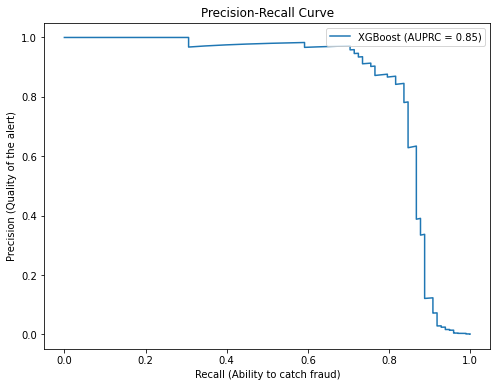

In [10]:
# 8. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AUPRC = {auprc:.2f})')
plt.xlabel('Recall (Ability to catch fraud)')
plt.ylabel('Precision (Quality of the alert)')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()